In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from io import StringIO
import numpy as np
import glob
import os
from tabulate import tabulate
from matplotlib.ticker import LogLocator, LogFormatterSciNotation, NullFormatter

In [5]:
CPU_CSV = Path(r"C:\Users\asus\Documents\Desmond's\Degree\FYP2\Simple-Makefile-McEliece\CPU_Timing(done).csv")

def _read_section(lines):
    """Read a single section (header + rows) into a clean DF with expected columns."""
    txt = "".join(lines)
    df = pd.read_csv(StringIO(txt), sep=None, engine="python")  # auto-detect delimiter (tabs/commas)
    # normalize expected column names
    df.columns = [c.strip().lower() for c in df.columns]
    rename = {
        "num_blocks": "num_blocks",
        "trial": "trial",
        "time_ms": "time_ms",
        "throughput": "throughput",
    }
    df = df.rename(columns=rename)
    missing = {"num_blocks", "trial", "time_ms", "throughput"} - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns in section: {missing}")

    # strip spaces and coerce
    df["trial"] = df["trial"].astype(str).str.strip()
    # separate AVG rows vs numeric trials
    is_avg = df["trial"].str.lower().eq("avg")
    df_trials = df.loc[~is_avg].copy()
    df_avg    = df.loc[ is_avg].copy()

    # numeric coercion for trials table
    for col in ["num_blocks", "trial", "time_ms", "throughput"]:
        if col == "trial":
            df_trials[col] = pd.to_numeric(df_trials[col], errors="coerce")
        else:
            df_trials[col] = pd.to_numeric(df_trials[col], errors="coerce")
    df_trials = df_trials.dropna(subset=["num_blocks", "trial", "time_ms", "throughput"])

    # numeric coercion for avg table (trial stays 'avg' string, keep numeric others)
    for col in ["num_blocks", "time_ms", "throughput"]:
        df_avg[col] = pd.to_numeric(df_avg[col], errors="coerce")
    df_avg = df_avg.dropna(subset=["num_blocks", "time_ms", "throughput"])

    return df_trials.reset_index(drop=True), df_avg.reset_index(drop=True)

def parse_cpu_two_tables(path: Path):
    """Split file at section markers into encrypt and decrypt dataframes (trials + avg)."""
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    sections = {}
    cur = None
    buf = []

    def flush(label):
        if not buf:
            return None
        try:
            return _read_section(buf)
        finally:
            buf.clear()

    for line in lines:
        s = line.strip()
        low = s.lower()
        # detect section starts
        if low.startswith("timing for cpu encrypt"):
            # flush previous if any
            if cur is not None and cur not in sections:
                sections[cur] = flush(cur)
            cur = "encrypt"
            buf = []
            continue
        if low.startswith("timing for cpu decrypt"):
            if cur is not None and cur not in sections:
                sections[cur] = flush(cur)
            cur = "decrypt"
            buf = []
            continue
        # collect header+rows for the current section
        if cur is not None and s:   # keep non-empty lines
            buf.append(line)

    # flush last section
    if cur is not None and cur not in sections:
        sections[cur] = flush(cur)

    if "encrypt" not in sections or "decrypt" not in sections:
        raise ValueError("Could not find both 'Timing for CPU encrypt' and 'Timing for CPU decrypt' sections.")

    (df_enc_trials, df_enc_avg) = sections["encrypt"]
    (df_dec_trials, df_dec_avg) = sections["decrypt"]

    return (df_enc_trials, df_enc_avg, df_dec_trials, df_dec_avg)

# Parse your file
df_enc_trials, df_enc_avg, df_dec_trials, df_dec_avg = parse_cpu_two_tables(CPU_CSV)

df_enc_trials.head(), df_enc_avg, df_dec_trials.head(), df_dec_avg


(   num_blocks  trial   time_ms   throughput
 0           1      1  0.040347  10806255.73
 1           1      2  0.065574   6648976.73
 2           1      3  0.064532   6756337.94
 3           1      4  0.038022  11467045.39
 4           1      5  0.064371   6773236.40,
    num_blocks trial   time_ms   throughput
 0           1   avg  0.044921  10917018.96
 1           2   avg  0.073283  13532555.18
 2           4   avg  0.139582  12782441.67
 3           8   avg  0.275987  12806684.73
 4          16   avg  0.560969  12542706.99
 5          32   avg  1.148872  12219651.07,
    num_blocks  trial   time_ms  throughput
 0           1      1  0.172907  2521586.75
 1           1      2  0.171674  2539697.33
 2           1      3  0.171123  2547874.92
 3           1      4  0.170792  2552812.78
 4           1      5  0.177766  2452662.49,
    num_blocks trial   time_ms  throughput
 0           1   avg  0.173462  2515560.08
 1           2   avg  0.343000  2542354.51
 2           4   avg  0.69

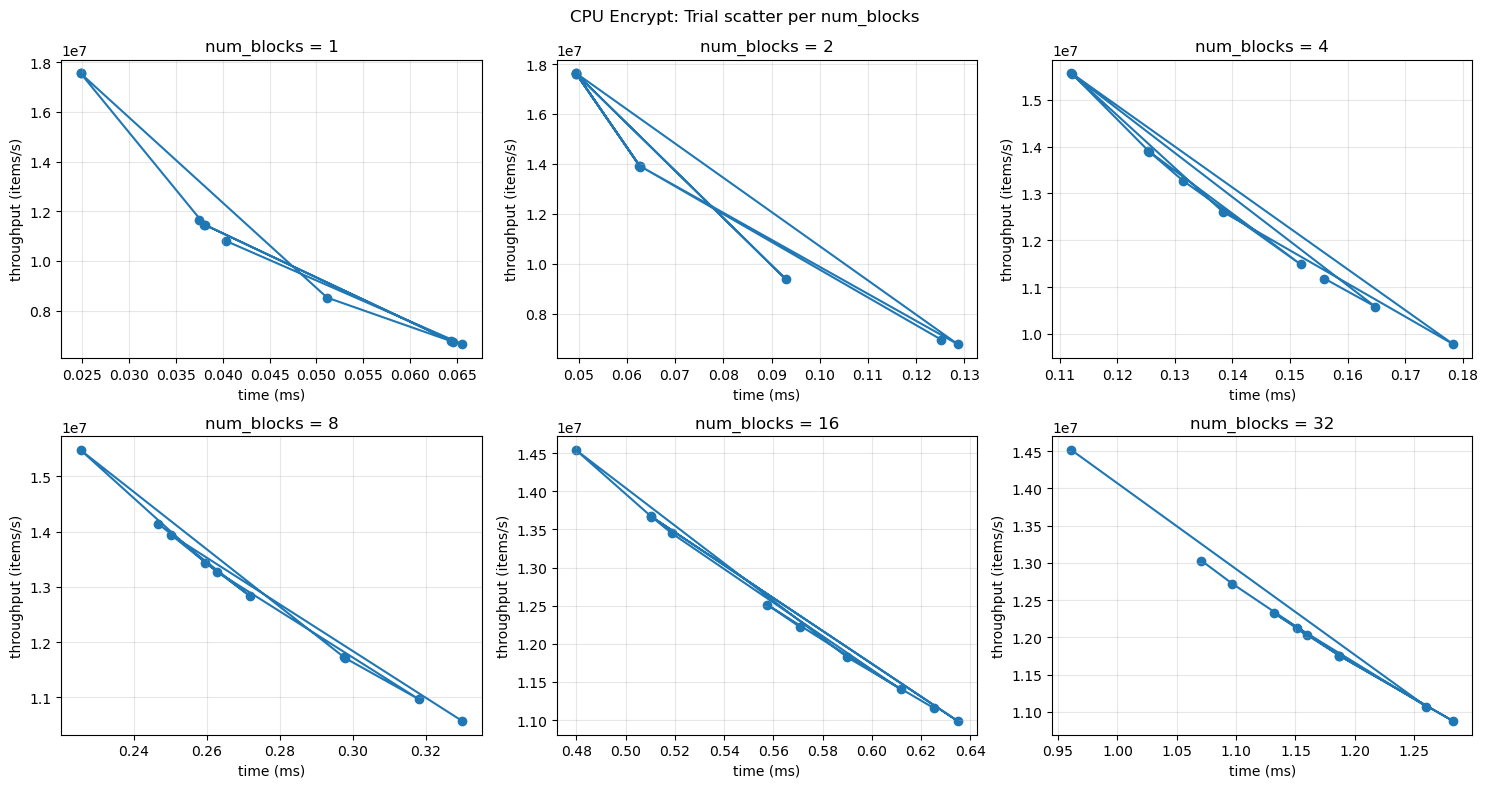

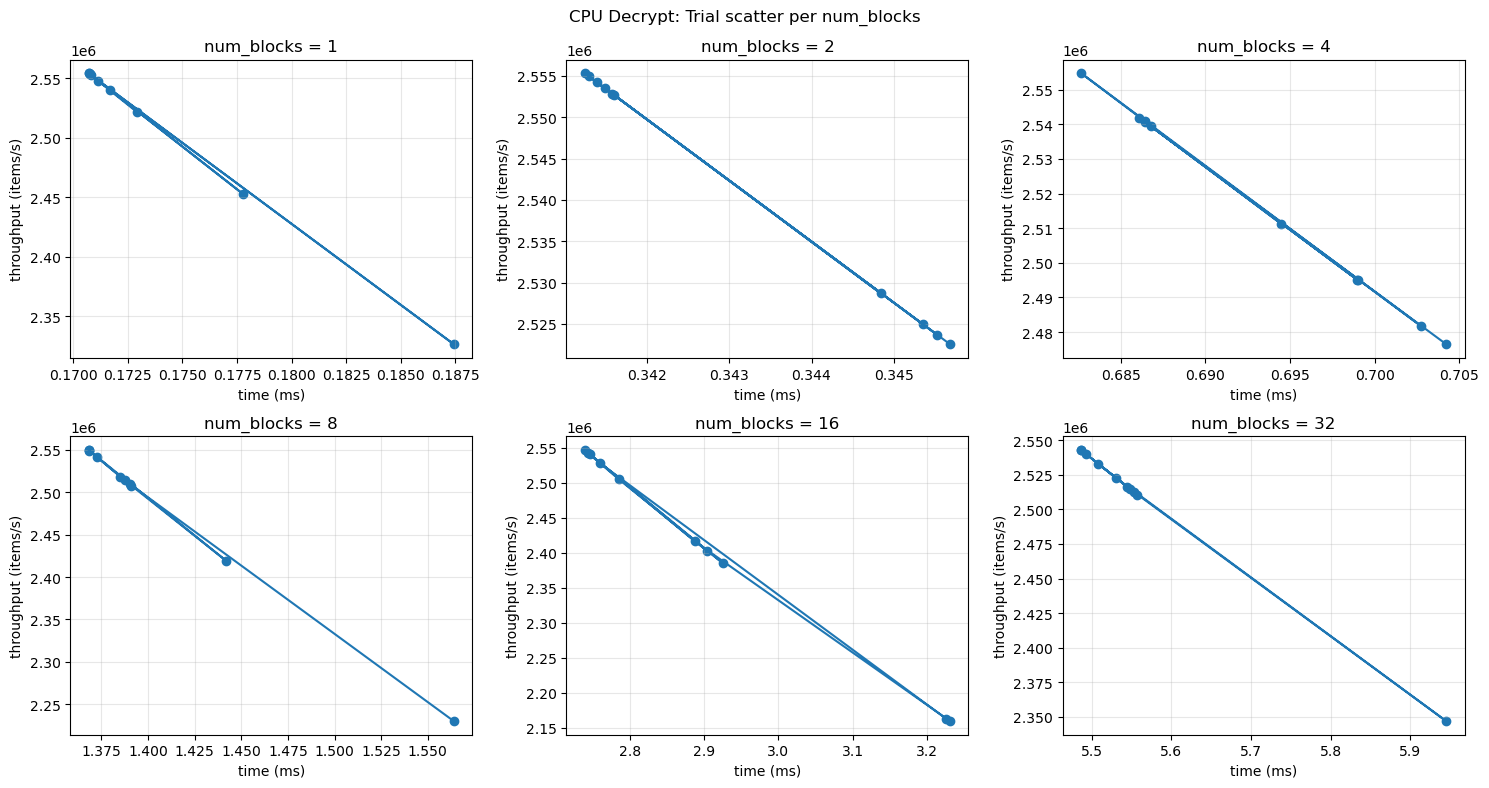

In [14]:


def scatter_trials(df_trials, title):
    # unique num_blocks ordered
    blocks = sorted(df_trials["num_blocks"].unique())

    # one figure with subplots per num_blocks (optional: tweak cols)
    n = len(blocks)
    ncols = 3
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
    ax_list = axes.ravel()

    for idx, nb in enumerate(blocks):
        ax = ax_list[idx]
        d = df_trials[df_trials["num_blocks"] == nb].sort_values("trial")
        ax.scatter(d["time_ms"], d["throughput"])
        ax.plot(d["time_ms"], d["throughput"])  # connect points in trial order (optional)
        ax.set_title(f"num_blocks = {nb}")
        ax.set_xlabel("time (ms)")
        ax.set_ylabel("throughput (items/s)")
        ax.grid(True, alpha=0.3)

    # hide any unused subplots
    for j in range(idx+1, len(ax_list)):
        fig.delaxes(ax_list[j])

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

scatter_trials(df_enc_trials, "CPU Encrypt: Trial scatter per num_blocks")
scatter_trials(df_dec_trials, "CPU Decrypt: Trial scatter per num_blocks")


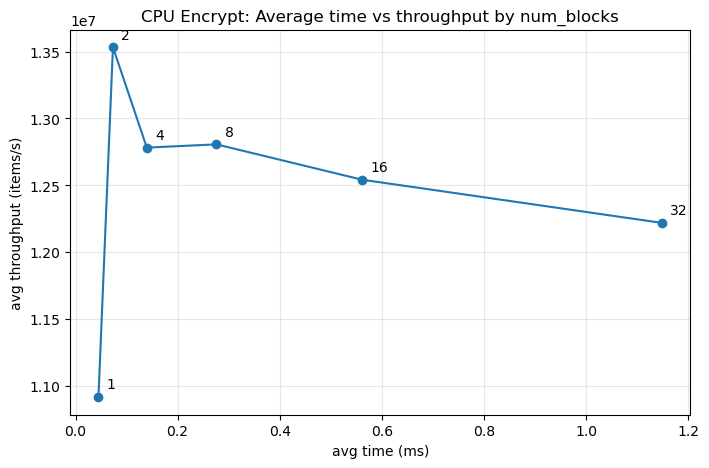

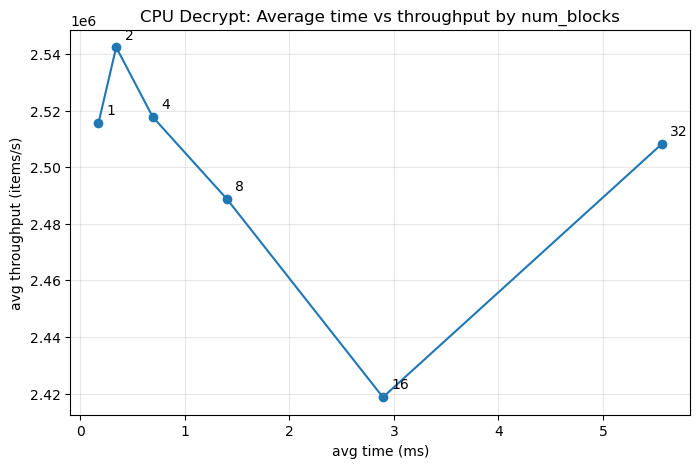

In [18]:
def ensure_avg(df_trials, df_avg):
    if df_avg.empty:
        # compute mean per num_blocks
        grp = df_trials.groupby("num_blocks", as_index=False).agg(
            time_ms=("time_ms","mean"),
            throughput=("throughput","mean")
        )
        grp["trial"] = "avg"
        return grp
    else:
        return df_avg.copy()

df_enc_avg_clean = ensure_avg(df_enc_trials, df_enc_avg)
df_dec_avg_clean = ensure_avg(df_dec_trials, df_dec_avg)

def plot_avg(df_avg, title):
    d = df_avg.sort_values("num_blocks")
    plt.figure(figsize=(8,5))
    plt.scatter(d["time_ms"], d["throughput"])
    plt.plot(d["time_ms"], d["throughput"])
    for _, row in d.iterrows():
        plt.annotate(int(row["num_blocks"]), (row["time_ms"], row["throughput"]), textcoords="offset points", xytext=(6,6))
    plt.title(title)
    plt.xlabel("avg time (ms)")
    plt.ylabel("avg throughput (items/s)")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_avg(df_enc_avg_clean, "CPU Encrypt: Average time vs throughput by num_blocks")
plot_avg(df_dec_avg_clean, "CPU Decrypt: Average time vs throughput by num_blocks")


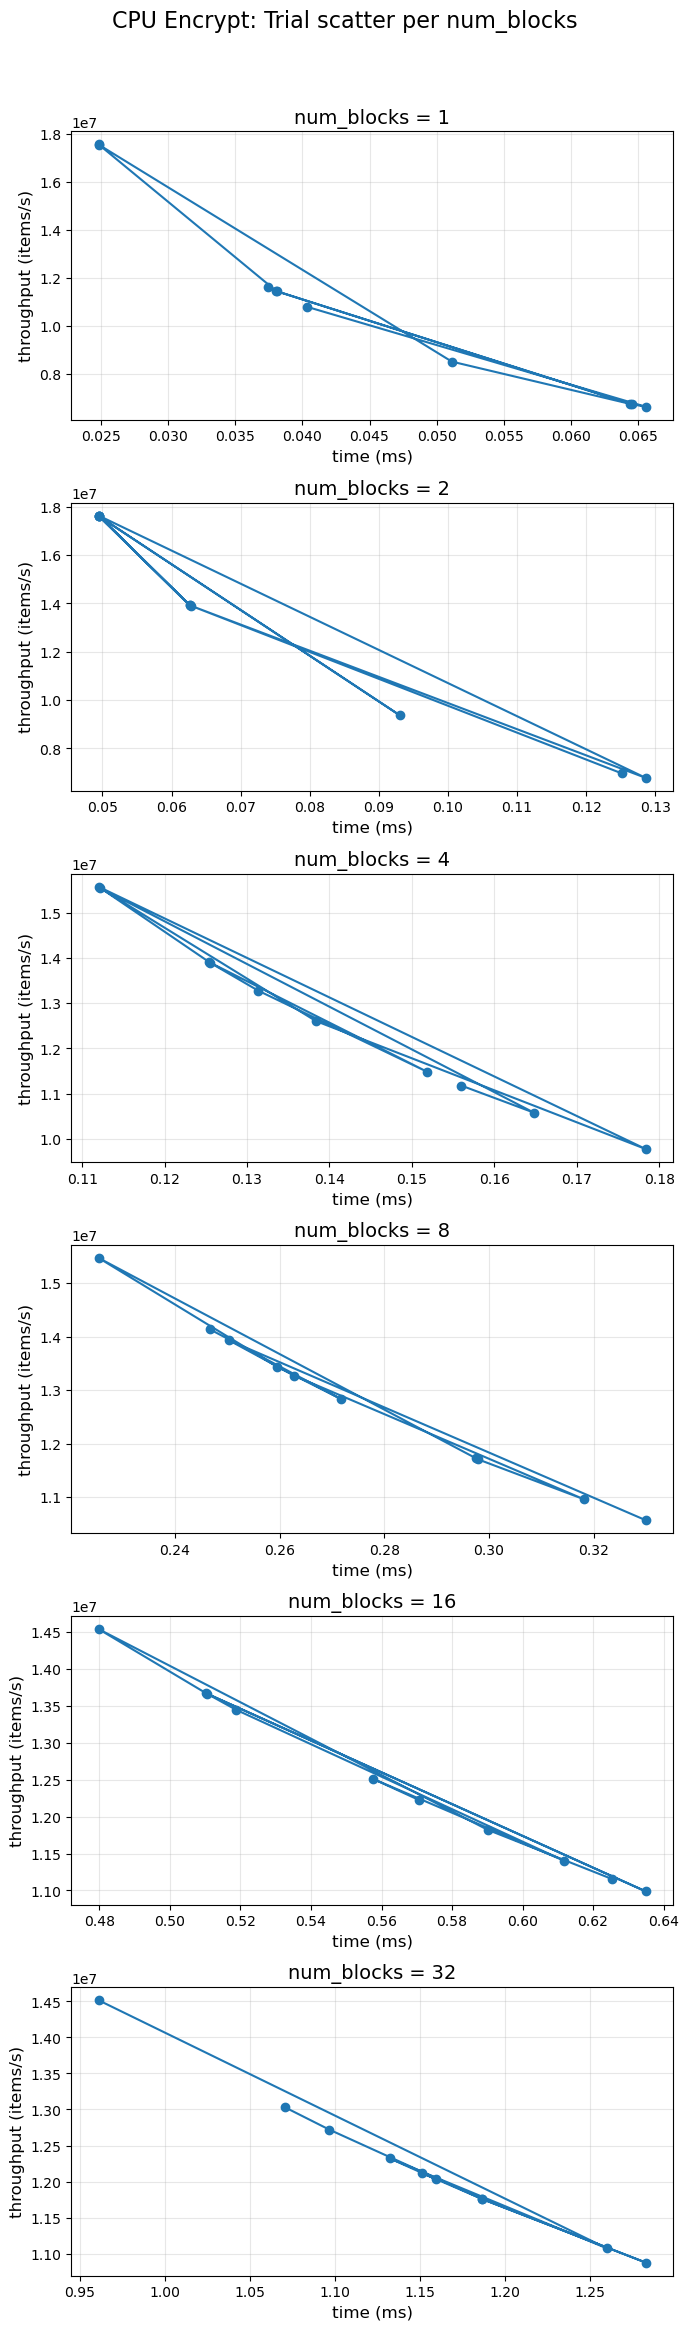

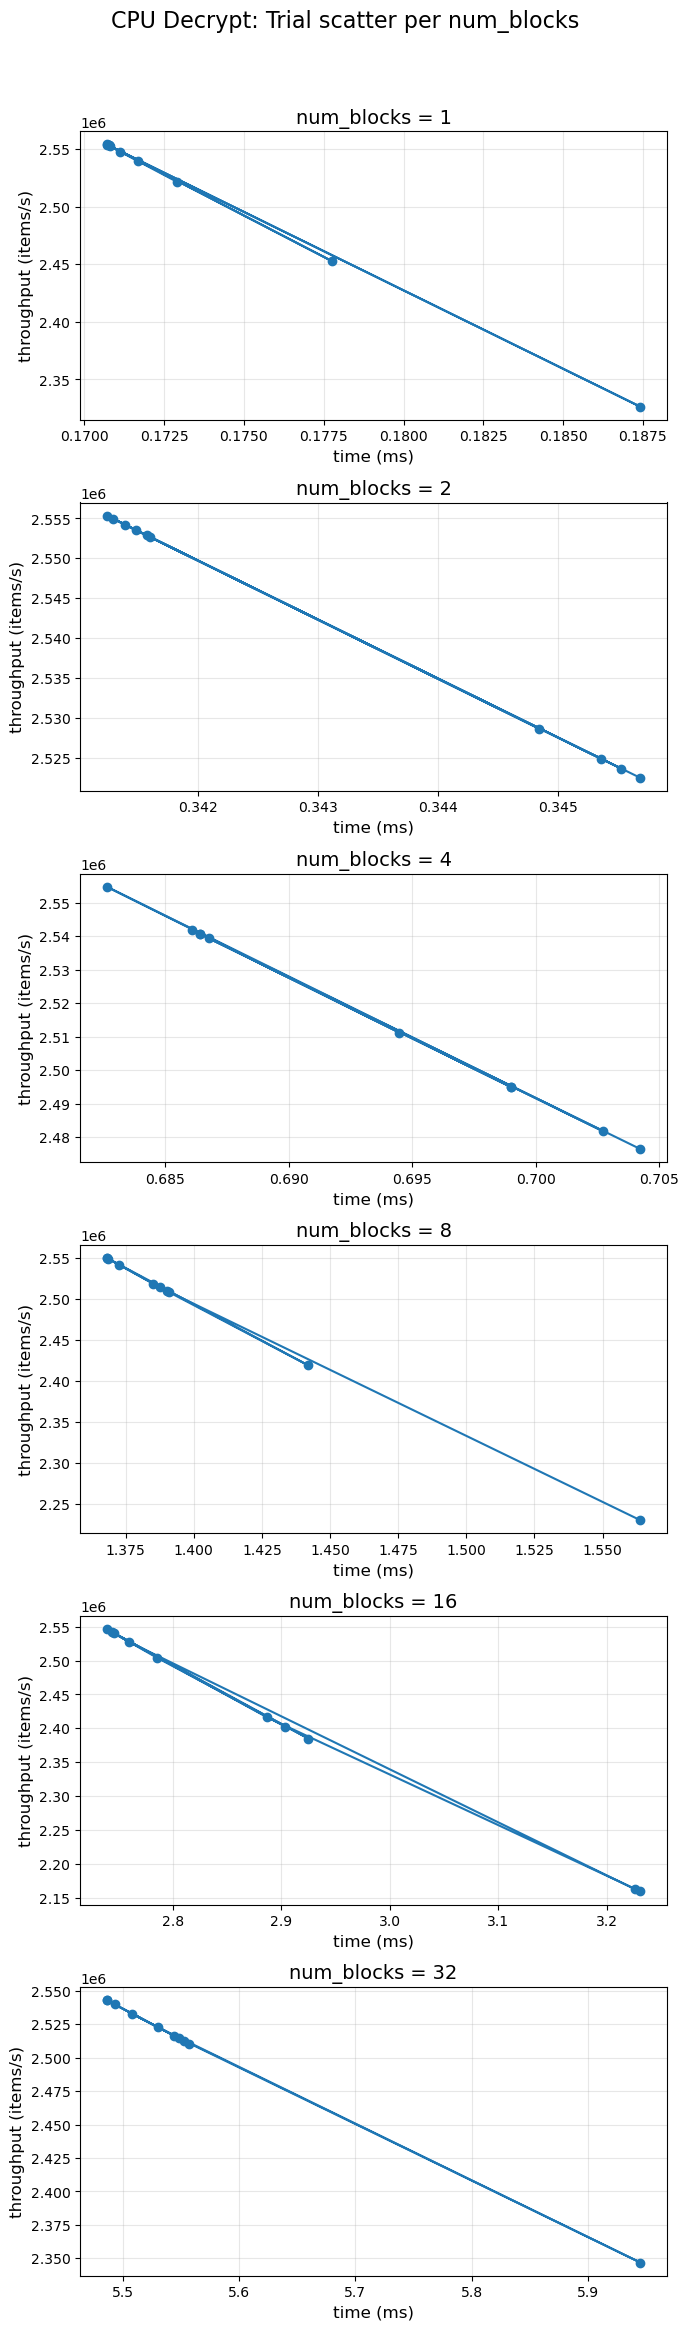

In [16]:
def scatter_trials_singlecol(df_trials, title, figsize_width=14, height_per_panel=3.6):
    # one column, N rows (one panel per num_blocks)
    blocks = sorted(df_trials["num_blocks"].unique())
    n = len(blocks)

    fig, axes = plt.subplots(n, 1, figsize=(figsize_width, height_per_panel * n), squeeze=False)
    ax_list = axes.ravel()

    for idx, nb in enumerate(blocks):
        ax = ax_list[idx]
        d = df_trials[df_trials["num_blocks"] == nb].sort_values("trial")
        ax.plot(d["time_ms"], d["throughput"], marker="o")
        ax.set_title(f"num_blocks = {nb}", fontsize=14)
        ax.set_xlabel("time (ms)", fontsize=12)
        ax.set_ylabel("throughput (items/s)", fontsize=12)
        ax.grid(True, alpha=0.3)

    # (in case of empty frames)
    for j in range(idx + 1, len(ax_list)):
        fig.delaxes(ax_list[j])

    fig.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# usage
scatter_trials_singlecol(df_enc_trials, "CPU Encrypt: Trial scatter per num_blocks",
                         figsize_width=7, height_per_panel=3.8)

scatter_trials_singlecol(df_dec_trials, "CPU Decrypt: Trial scatter per num_blocks",
                         figsize_width=7, height_per_panel=3.8)


In [22]:
# Use raw string to avoid issues with backslashes and apostrophes
csv_path_enc = r"C:\Users\asus\Documents\Desmond's\Degree\FYP2\Simple-Makefile-McEliece\results_enc"

# Load all CSVs
csv_files_enc = glob.glob(os.path.join(csv_path_enc, "*.csv"))
dataframes = [pd.read_csv(file) for file in csv_files_enc]

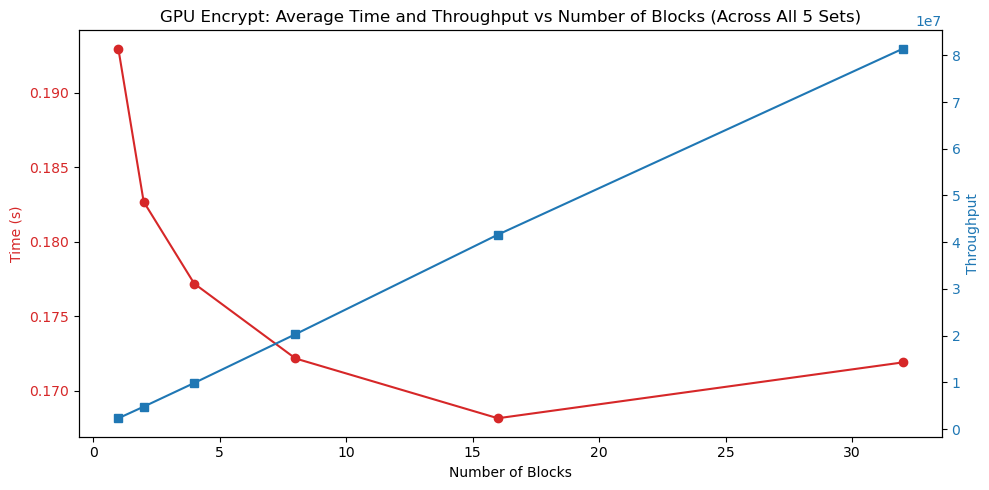

In [24]:
#Final average results of the 10 runs combined
all_avg_rows = []

for file in csv_files_enc:
    df = pd.read_csv(file)
    
    # Step 3: Filter only the rows with trial == 'avg'
    avg_rows = df[df['trial'] == 'avg'].copy()
    
    # Ensure numeric types
    avg_rows['time_ms'] = pd.to_numeric(avg_rows['time_ms'], errors='coerce')
    avg_rows['throughput'] = pd.to_numeric(avg_rows['throughput'], errors='coerce')
    
    all_avg_rows.append(avg_rows)

# Step 4: Combine all average rows from all files into one DataFrame
combined_avg_df = pd.concat(all_avg_rows)

# Step 5: Group by num_blocks and calculate final average
final_avg = combined_avg_df.groupby('num_blocks')[['time_ms', 'throughput']].mean().reset_index()

# Step 6: Plotting the simplified results
fig, ax1 = plt.subplots(figsize=(10, 5))

color1 = 'tab:red'
ax1.set_xlabel('Number of Blocks')
ax1.set_ylabel('Time (s)', color=color1)
ax1.plot(final_avg['num_blocks'], final_avg['time_ms'], color=color1, marker='o', label='Time (s)')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Throughput', color=color2)
ax2.plot(final_avg['num_blocks'], final_avg['throughput'], color=color2, marker='s', label='Throughput')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('GPU Encrypt: Average Time and Throughput vs Number of Blocks (Across All 5 Sets)')
fig.tight_layout()
plt.show()

In [25]:
# Table 1: Time vs Number of Blocks
time_table = final_avg[['num_blocks', 'time_ms']].copy()
time_table['time_ms'] = time_table['time_ms'].apply(lambda x: f"{x:.6f}")
print("GPU encrypt: Time (ms) vs Number of Blocks:")
print(tabulate(time_table, headers='keys', tablefmt='pretty'))
print("\n")  # Newline for separation

# Table 2: Throughput vs Number of Blocks
throughput_table = final_avg[['num_blocks', 'throughput']]
print("GPU encrypt: Throughput (items/sec) vs Number of Blocks:")
print(tabulate(throughput_table, headers='keys', tablefmt='pretty'))

GPU encrypt: Time (ms) vs Number of Blocks:
+---+------------+----------+
|   | num_blocks | time_ms  |
+---+------------+----------+
| 0 |     1      | 0.192954 |
| 1 |     2      | 0.182693 |
| 2 |     4      | 0.177197 |
| 3 |     8      | 0.172177 |
| 4 |     16     | 0.168165 |
| 5 |     32     | 0.171911 |
+---+------------+----------+


GPU encrypt: Throughput (items/sec) vs Number of Blocks:
+---+------------+------------+
|   | num_blocks | throughput |
+---+------------+------------+
| 0 |    1.0     | 2314525.8  |
| 1 |    2.0     | 4791434.8  |
| 2 |    4.0     | 9871298.0  |
| 3 |    8.0     | 20305654.4 |
| 4 |    16.0    | 41614452.0 |
| 5 |    32.0    | 81403555.2 |
+---+------------+------------+


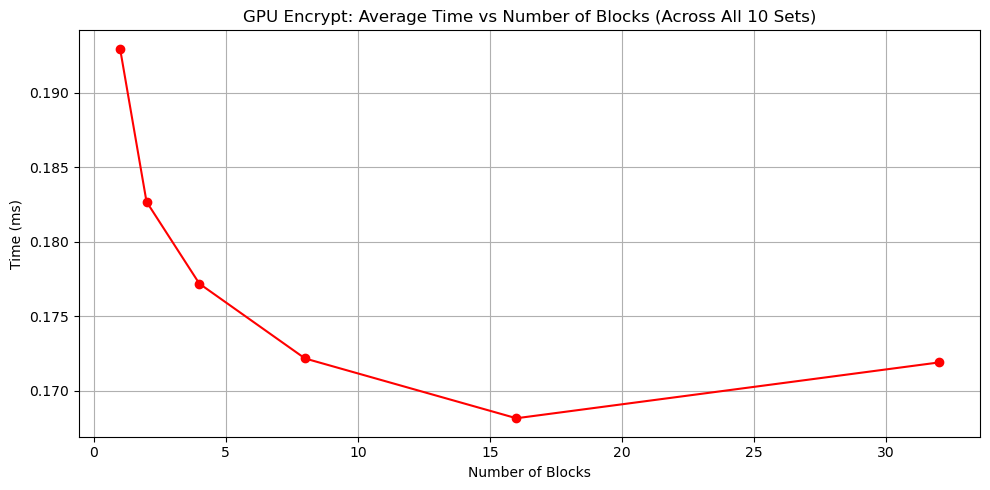

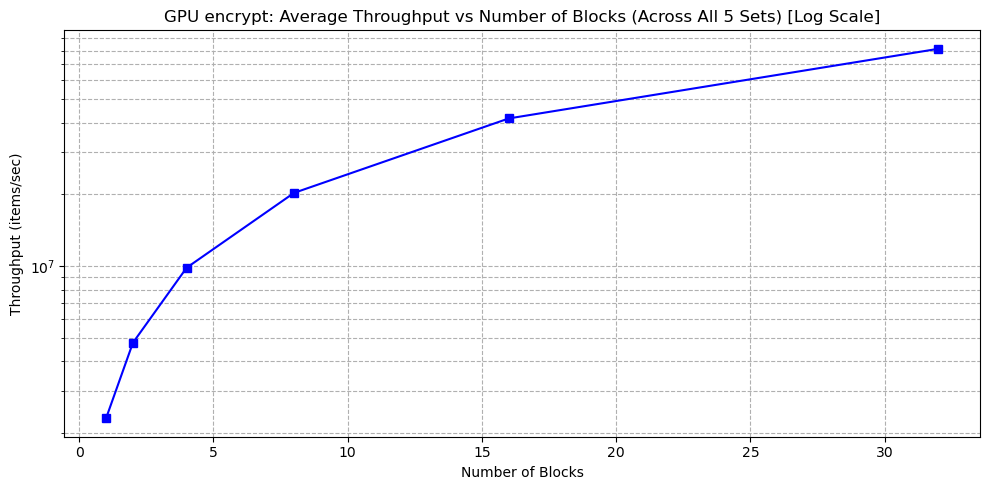

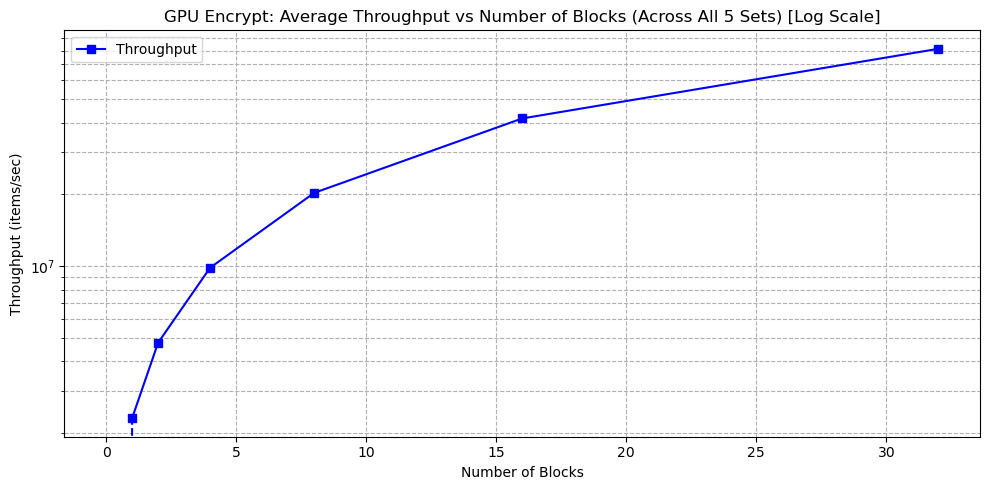

In [30]:
# Final average results of the 10 runs combined
all_avg_rows = []

for file in csv_files_enc:
    df = pd.read_csv(file)
    
    # Filter only the rows with trial == 'avg'
    avg_rows = df[df['trial'] == 'avg'].copy()
    
    # Ensure numeric types
    avg_rows['time_ms'] = pd.to_numeric(avg_rows['time_ms'], errors='coerce')
    avg_rows['throughput'] = pd.to_numeric(avg_rows['throughput'], errors='coerce')
    
    all_avg_rows.append(avg_rows)

# Combine all average rows from all files into one DataFrame
combined_avg_df = pd.concat(all_avg_rows)

# Group by num_blocks and calculate final average
final_avg = combined_avg_df.groupby('num_blocks')[['time_ms', 'throughput']].mean().reset_index()

# Plot 1: Time vs Number of Blocks
plt.figure(figsize=(10, 5))
plt.plot(final_avg['num_blocks'], final_avg['time_ms'], color='red', marker='o')
plt.title('GPU Encrypt: Average Time vs Number of Blocks (Across All 10 Sets)')
plt.xlabel('Number of Blocks')
plt.ylabel('Time (ms)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Throughput vs Number of Blocks (Log scale)
plt.figure(figsize=(10, 5))
plt.plot(final_avg['num_blocks'], final_avg['throughput'], color='blue', marker='s')
plt.yscale('log')  # Set y-axis to logarithmic
plt.title('GPU encrypt: Average Throughput vs Number of Blocks (Across All 5 Sets) [Log Scale]')
plt.xlabel('Number of Blocks')
plt.ylabel('Throughput (items/sec)')
plt.grid(True, which='both', linestyle='--')  # Grid for both major and minor ticks
plt.tight_layout()
plt.show()

# Plot 2: Throughput vs Number of Blocks (Log scale)
plt.figure(figsize=(10, 5))

# Plot the main data
plt.plot(final_avg['num_blocks'], final_avg['throughput'], color='blue', marker='s', label='Throughput')

 # Add the connecting line from (0, 0) to the first real data point
first_x = final_avg['num_blocks'].iloc[0]
first_y = final_avg['throughput'].iloc[0]
plt.plot([0, first_x], [0, first_y], color='blue', linestyle='--', marker='')  # Dashed line from origin

plt.yscale('log')  # Set y-axis to logarithmic

plt.title('GPU Encrypt: Average Throughput vs Number of Blocks (Across All 5 Sets) [Log Scale]')
plt.xlabel('Number of Blocks')
plt.ylabel('Throughput (items/sec)')
plt.grid(True, which='both', linestyle='--')  # Grid for both major and minor ticks
plt.tight_layout()
plt.legend()
plt.show()

In [31]:
# Use raw string to avoid issues with backslashes and apostrophes
csv_path_dec = r"C:\Users\asus\Documents\Desmond's\Degree\FYP2\Simple-Makefile-McEliece\results_dec"

# Load all CSVs
csv_files_dec = glob.glob(os.path.join(csv_path_dec, "*.csv"))
dataframes = [pd.read_csv(file) for file in csv_files_dec]

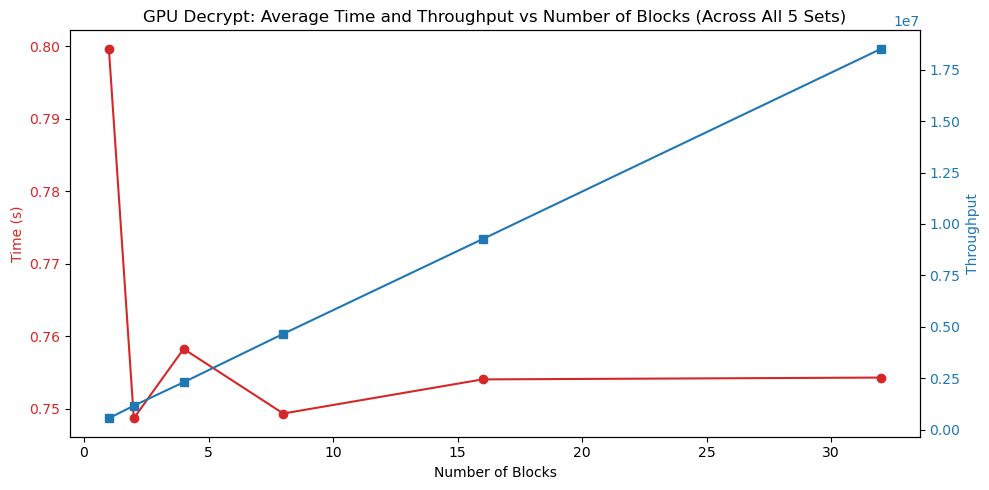

In [33]:
#Final average results of the 10 runs combined
all_avg_rows = []

for file in csv_files_dec:
    df = pd.read_csv(file)
    
    # Step 3: Filter only the rows with trial == 'avg'
    avg_rows = df[df['trial'] == 'avg'].copy()
    
    # Ensure numeric types
    avg_rows['time_ms'] = pd.to_numeric(avg_rows['time_ms'], errors='coerce')
    avg_rows['throughput'] = pd.to_numeric(avg_rows['throughput'], errors='coerce')
    
    all_avg_rows.append(avg_rows)

# Step 4: Combine all average rows from all files into one DataFrame
combined_avg_df = pd.concat(all_avg_rows)

# Step 5: Group by num_blocks and calculate final average
final_avg = combined_avg_df.groupby('num_blocks')[['time_ms', 'throughput']].mean().reset_index()

# Step 6: Plotting the simplified results
fig, ax1 = plt.subplots(figsize=(10, 5))

color1 = 'tab:red'
ax1.set_xlabel('Number of Blocks')
ax1.set_ylabel('Time (s)', color=color1)
ax1.plot(final_avg['num_blocks'], final_avg['time_ms'], color=color1, marker='o', label='Time (s)')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Throughput', color=color2)
ax2.plot(final_avg['num_blocks'], final_avg['throughput'], color=color2, marker='s', label='Throughput')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('GPU Decrypt: Average Time and Throughput vs Number of Blocks (Across All 5 Sets)')
fig.tight_layout()
plt.show()

In [34]:
# Table 1: Time vs Number of Blocks
time_table = final_avg[['num_blocks', 'time_ms']].copy()
time_table['time_ms'] = time_table['time_ms'].apply(lambda x: f"{x:.6f}")
print("GPU Decrypt: Time (ms) vs Number of Blocks:")
print(tabulate(time_table, headers='keys', tablefmt='pretty'))
print("\n")  # Newline for separation

# Table 2: Throughput vs Number of Blocks
throughput_table = final_avg[['num_blocks', 'throughput']]
print("GPU Decrypt: Throughput (items/sec) vs Number of Blocks:")
print(tabulate(throughput_table, headers='keys', tablefmt='pretty'))

GPU Decrypt: Time (ms) vs Number of Blocks:
+---+------------+----------+
|   | num_blocks | time_ms  |
+---+------------+----------+
| 0 |     1      | 0.799638 |
| 1 |     2      | 0.748664 |
| 2 |     4      | 0.758231 |
| 3 |     8      | 0.749318 |
| 4 |     16     | 0.754025 |
| 5 |     32     | 0.754278 |
+---+------------+----------+


GPU Decrypt: Throughput (items/sec) vs Number of Blocks:
+---+------------+-------------+
|   | num_blocks | throughput  |
+---+------------+-------------+
| 0 |    1.0     |  553932.7   |
| 1 |    2.0     | 1165266.352 |
| 2 |    4.0     | 2303712.95  |
| 3 |    8.0     |  4657335.6  |
| 4 |    16.0    |  9264162.4  |
| 5 |    32.0    | 18515560.0  |
+---+------------+-------------+


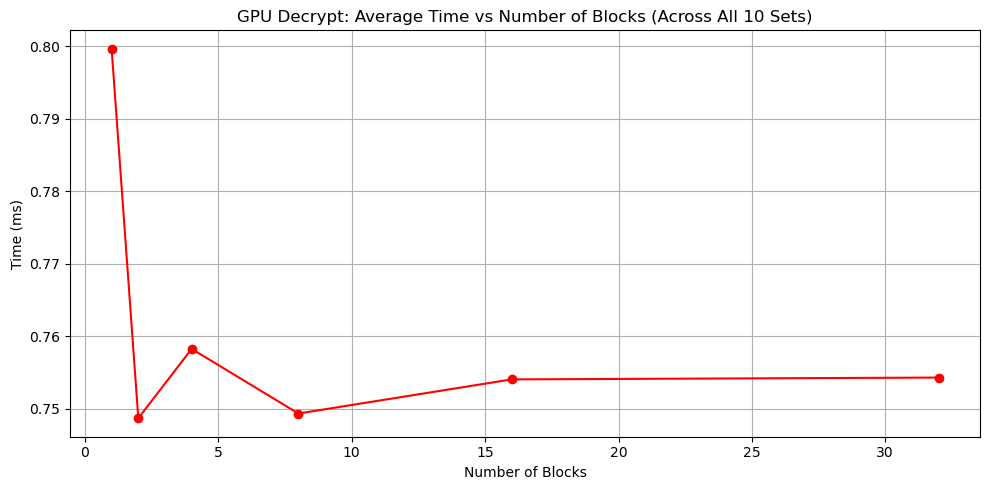

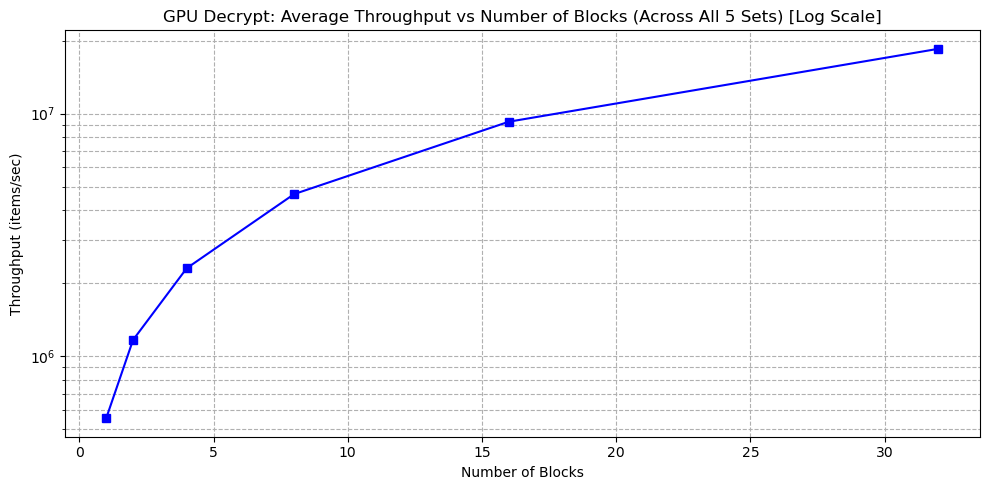

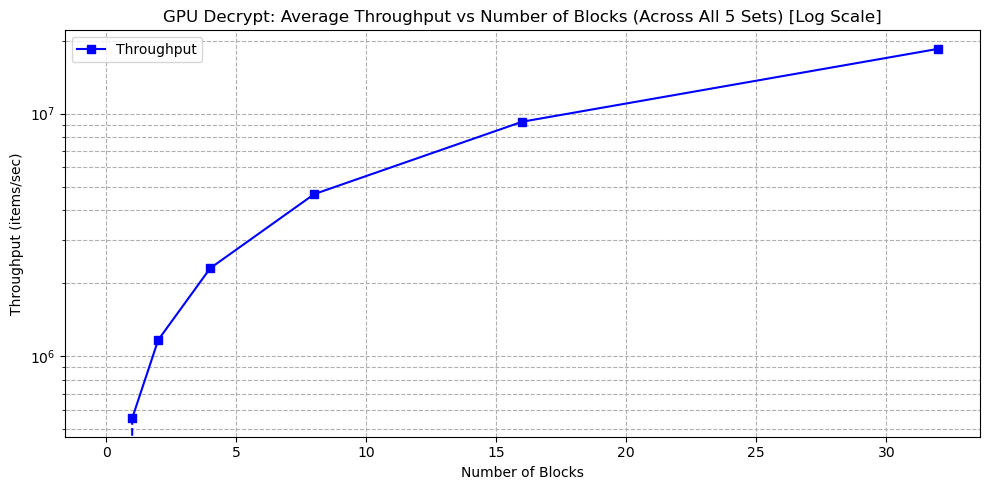

In [35]:
# Final average results of the 10 runs combined
all_avg_rows = []

for file in csv_files_dec:
    df = pd.read_csv(file)
    
    # Filter only the rows with trial == 'avg'
    avg_rows = df[df['trial'] == 'avg'].copy()
    
    # Ensure numeric types
    avg_rows['time_ms'] = pd.to_numeric(avg_rows['time_ms'], errors='coerce')
    avg_rows['throughput'] = pd.to_numeric(avg_rows['throughput'], errors='coerce')
    
    all_avg_rows.append(avg_rows)

# Combine all average rows from all files into one DataFrame
combined_avg_df = pd.concat(all_avg_rows)

# Group by num_blocks and calculate final average
final_avg = combined_avg_df.groupby('num_blocks')[['time_ms', 'throughput']].mean().reset_index()

# Plot 1: Time vs Number of Blocks
plt.figure(figsize=(10, 5))
plt.plot(final_avg['num_blocks'], final_avg['time_ms'], color='red', marker='o')
plt.title('GPU Decrypt: Average Time vs Number of Blocks (Across All 10 Sets)')
plt.xlabel('Number of Blocks')
plt.ylabel('Time (ms)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Throughput vs Number of Blocks (Log scale)
plt.figure(figsize=(10, 5))
plt.plot(final_avg['num_blocks'], final_avg['throughput'], color='blue', marker='s')
plt.yscale('log')  # Set y-axis to logarithmic
plt.title('GPU Decrypt: Average Throughput vs Number of Blocks (Across All 5 Sets) [Log Scale]')
plt.xlabel('Number of Blocks')
plt.ylabel('Throughput (items/sec)')
plt.grid(True, which='both', linestyle='--')  # Grid for both major and minor ticks
plt.tight_layout()
plt.show()

# Plot 2: Throughput vs Number of Blocks (Log scale)
plt.figure(figsize=(10, 5))

# Plot the main data
plt.plot(final_avg['num_blocks'], final_avg['throughput'], color='blue', marker='s', label='Throughput')

 # Add the connecting line from (0, 0) to the first real data point
first_x = final_avg['num_blocks'].iloc[0]
first_y = final_avg['throughput'].iloc[0]
plt.plot([0, first_x], [0, first_y], color='blue', linestyle='--', marker='')  # Dashed line from origin

plt.yscale('log')  # Set y-axis to logarithmic

plt.title('GPU Decrypt: Average Throughput vs Number of Blocks (Across All 5 Sets) [Log Scale]')
plt.xlabel('Number of Blocks')
plt.ylabel('Throughput (items/sec)')
plt.grid(True, which='both', linestyle='--')  # Grid for both major and minor ticks
plt.tight_layout()
plt.legend()
plt.show()